# Distributed Training with Keras & Tensorflow

Training a model can be extremely compute intensive, even for relatively small problems and even with access to powerful GPU hardware, network training can run for many hours, days or weeks!

If you are experimenting or learning machine learning with Tensorflow, and you have access to multiple machines (with or without GPUs), you can make your training run a bit faster by using the [inbuilt multi-worker](https://www.tensorflow.org/tutorials/distribute/multi_worker_with_keras) features which come with Keras and Tensorflow.

## Caveats

If you are just now starting with Tensorflow, you should know that it can be **extremely** finicky, and Tensorflow documentation really needs to be understood properly to work out problems along the way. Before you try any form of distributed workloads, ensure the following:

- You have a stable Tensorflow/Keras environment which is of a recent enough version (2.15.x+)
- You have multiple nodes in the same network with good connectivity
- All nodes **should** have the same version of Tensorflow and Keras

Even with the above considerations, you might find that some things might or might not work very well, for example, I couldn't get distributed model predictions to work in my environment (therefore, saving the model and reloading it when predicting).


## Setting up a distributed environment

To illustrate multi-worker distribution, we are going to set up a two node environment. In this case running on a Mac Mini and a Macbook with Apple silicon.

Here are my software versions:


In [1]:
import tensorflow as tf
import keras as k

print("Tensorflow version is " + tf.__version__)
print("Keras version is " + k.__version__)

Tensorflow version is 2.16.1
Keras version is 3.0.5


## Files

For clarity, we will be setting up the environment in three separate files with different methods. This is for illustration only, and you can go about a different way.

## Setting up nodes

Tensorflow uses the `TF_CONFIG` environment variable for configuration. In a multi-worker setup we need to define our cluster in this environment variable.

In [2]:
%%writefile env_setup.py

import json
import os

def set_env():
    tf_config = {
        'cluster': {
            'worker': ['pedros-macbook-pro-3.local:9999'],
            'chief': ['macmini.local:9999'],
        },
        'task': {'type': 'chief', 'index': 0}
    }

    # Serialize tf_config and export it as an environment variable
    os.environ['TF_CONFIG'] = json.dumps(tf_config)
    # Disable INFO and WARNING logs
    os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

Overwriting env_setup.py


We are defining a cluster of two machines - `macmini.local` and `pedros-macbook-pro-3.local`, one setup as a Tensorflow worker, and the other as the chief (note that the chief also performs training tasks). The above file will need to be changed on each machine, so that `index` points at the right role (chief in `macmini.local` and worker for `pedros-macbook-pro-3.local`). You can add additional nodes if that is the case in your environment.

In addition we are also disabling `INFO` and `WARNING` messages, as in my particular case they can get a bit noisy. For `pedros-macbook-pro-3.local`, the same file would be as follows.

In [3]:
import json
import os

def set_env():
    tf_config = {
        'cluster': {
            'worker': ['pedros-macbook-pro-3.local:9999'],
            'chief': ['macmini.local:9999'],
        },
        'task': {'type': 'worker', 'index': 0}
    }

    # Serialize tf_config and export it as an environment variable
    os.environ['TF_CONFIG'] = json.dumps(tf_config)
    # Disable INFO and WARNING logs
    os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

## Setting up the model

For illustration, we will be setting up a very simple linear regression model with a single `Dense` layer. Our dataset is just a set of X,Y points.

In [4]:
%%writefile model_setup.py

import os
import numpy as np

from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.data import Dataset

def build_dataset(strategy, global_batch_size):
  # Generate a dataset
  np.random.seed(42)  # For reproducibility
  x = np.linspace(-1, 1, 1000)  # 1000 linearly spaced numbers
  y = 2 * x + 1 + np.random.normal(scale=0.1, size=x.shape)  # Linear equation with noise

  # Create a TensorFlow dataset
  dataset = Dataset.from_tensor_slices((x[:, None], y))
  # Shuffle, batch, and repeat
  dataset = dataset.shuffle(buffer_size=1000).batch(global_batch_size).repeat()
    
  return dataset

def plot_dataset_and_predictions(dataset, pred_x, pred_y):
  import matplotlib.pyplot as plt
  for x, y in dataset.take(1):
    plt.scatter(x, y, label='Data')
  plt.scatter(pred_x, pred_y, label='Predictions')
  plt.legend()
  plt.show()

def build_model():
  input_layer = Input(shape=(1,))
  output_layer = Dense(units=1)(input_layer)
  model = Model(inputs=input_layer, outputs=output_layer)

  model.compile(optimizer=Adam(learning_rate=0.1),
                loss='mean_squared_error',
                metrics=['mae'])
  return model

# Predict n random values from -1 to 1 using the trained model and return the predictions
def predict(model, n):
  x = np.random.uniform(-1, 1, n)
  y = model.predict(x)
  return x, y

Overwriting model_setup.py


An important consideration is that your mileage may very, depending on the complexity of the workload you want to distribute, as well on specific hardware you might have. For example, in my case multi-worked distribution across Apple Silicon chips doesn't work when running on GPUs (I think this is an issue with Apple's [Tensorflow-Metal](https://developer.apple.com/metal/tensorflow-plugin/)). Worst case scenario you might need to disable GPU computation and stick to CPU only.

## The worker process

We are now ready to create a process to run and distribute the workload. You will notice we are disabling GPU devices (because of the above) with `set_visible_devices`. The worker needs to be started on all the nodes involved, in my case `mini.local` and `pedros-macbook-pro-3.local`. The first node to start becomes the "chief" node which will distribute the workload amongst workers - in Tensorflow the "chief" node is also a worker.

In [5]:
%%writefile worker.py

import os
import json

import numpy as np
import tensorflow as tf
from tensorflow.config import set_visible_devices
import model_setup
import env_setup

def worker_setup():
    # Setup for distributed training
    env_setup.set_env()
    # Hide GPU from visible devices
    set_visible_devices([], 'GPU')

def run_worker():
    # Set up a MultiWorkerMirroredStrategy
    strategy = tf.distribute.MultiWorkerMirroredStrategy()

    # Assume global batch size and calculate per-replica batch size
    GLOBAL_BATCH_SIZE = 50
    # Build dataset with the specified global batch size
    dataset = model_setup.build_dataset(strategy, GLOBAL_BATCH_SIZE)
    # Calculate steps per epoch based on your actual dataset size
    # Here, 1000 is the number of samples in the dataset
    STEPS_PER_EPOCH = 1000 // GLOBAL_BATCH_SIZE

    with strategy.scope():
        # Model building/compiling need to be within `strategy.scope()`.
        multi_worker_model = model_setup.build_model()

    multi_worker_model.fit(dataset, epochs=10, steps_per_epoch=STEPS_PER_EPOCH)
    print("Exiting worker...")

    return multi_worker_model, dataset

Overwriting worker.py


In [6]:
%%writefile runner.py

import tensorflow as tf
from worker import worker_setup, run_worker

worker_setup()
trained_model, dataset = run_worker()
print("Worker finished...")
trained_model.save("trained_model.keras")
tf.data.Dataset.save(dataset, "dataset.keras")

Overwriting runner.py


In [7]:
%%writefile predict.py

import tensorflow as tf
from model_setup import predict, plot_dataset_and_predictions

saved_model = tf.keras.models.load_model("trained_model.keras")
saved_dataset = tf.data.Dataset.load("dataset.keras", element_spec=None)
pred_x, pred_y = predict(saved_model, 100)
plot_dataset_and_predictions(saved_dataset, pred_x, pred_y)

Overwriting predict.py


## Distribution strategies

Tensorflow supports [multiple strategies](https://www.tensorflow.org/guide/distributed_training) to distribute the workload. In our case we are using `MultiWorkerMirroredStrategy`, which distributes variables for training across multiple nodes, with or without GPUs. If you wanted to distribute your training in a single node with multiple GPUs, you would use `MirroredStrategy` instead.

## Running the workers

You would now start `runner.py` in each of your machines to run the distributed model, paying attention to any messages you might get. It is possible you will need to trial an error until you get everything just right.

In [ ]:
%run runner.py

INFO:tensorflow:Enabled multi-worker collective ops with available devices: ['/job:chief/replica:0/task:0/device:CPU:0', '/job:worker/replica:0/task:0/device:CPU:0']
INFO:tensorflow:Using MirroredStrategy with devices ('/job:chief/task:0/device:CPU:0',)
INFO:tensorflow:Check health not enabled.
INFO:tensorflow:MultiWorkerMirroredStrategy with cluster_spec = {'worker': ['pedros-macbook-pro-3.local:9999'], 'chief': ['macmini.local:9999']}, task_type = 'chief', task_id = 0, num_workers = 2, local_devices = ('/job:chief/task:0/device:CPU:0',), communication = CommunicationImplementation.AUTO


I0000 00:00:1710684877.465218 3612918 coordination_service_agent.cc:303] Coordination agent has successfully connected.


Epoch 1/10
INFO:tensorflow:Collective all_reduce tensors: 1 all_reduces, num_devices = 1, group_size = 2, implementation = CommunicationImplementation.AUTO, num_packs = 1
INFO:tensorflow:Collective all_reduce tensors: 1 all_reduces, num_devices = 1, group_size = 2, implementation = CommunicationImplementation.AUTO, num_packs = 1
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 46ms/step - loss: 1.5073 - mae: 1.2994
Epoch 2/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 40ms/step - loss: 0.1458 - mae: 0.4487
Epoch 3/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 40ms/step - loss: 0.0306 - mae: 0.1988
Epoch 4/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 47ms/step - loss: 0.0200 - mae: 0.1575
Epoch 5/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step - loss: 0.0191 - mae: 0.1523
Epoch 6/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step - loss: 0.0201 - mae: 0.1594
Epoch 7/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 46ms/step - loss: 0.0203 - mae: 0.1598
Epoch 8/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step - loss: 0.0185 - mae: 0.1512
Epoch 9/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s

If all went well, you will have seen the model being trained across your multiple devices. We can visualise our dataset to illustrate what the model solved for.

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


2024-03-17 14:19:56.862745: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M2
2024-03-17 14:19:56.862767: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 24.00 GB
2024-03-17 14:19:56.862771: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 8.00 GB
2024-03-17 14:19:56.862970: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-03-17 14:19:56.862980: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)
2024-03-17 14:19:56.971956: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.
2024-03-17 14:19:57.281807: W t

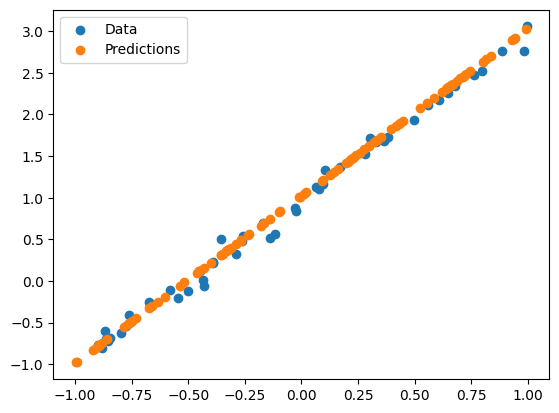

In [1]:
%run predict.py